In [ ]:
import os
import numpy as np
from scipy.special import logsumexp
import pandas as pd
import tensorflow as tf
from tqdm import tqdm
import pickle
import json
import regex as re

import matplotlib.pyplot as plt
plt.style.use("ggplot")

print(tf.__version__)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [21]:
TAGS =  pickle.load(open( "tags.pickle", "rb" ))
TAGS.remove("O") 
NUM_TAGS = len(TAGS)

In [22]:
tag2id = {}
for id,label in enumerate(TAGS):
    tag2id[label] = id 

def label2id(labels):
    ret = []
    prev_label = ""
    for label in labels:
        if label == "O":
            ret.append(str(2*NUM_TAGS))
        elif label == prev_label:
            l = [tag2id[t]+ NUM_TAGS for t in label]
            for x in l:
                ret.append(str(x))
        else:
            l =[tag2id[t] for t in label]
            for x in l:
                ret.append(str(x))
        prev_label = label
    return ret 

In [24]:
def get_label(label_id):
    if label_id == (2*NUM_TAGS):
        return "O"
    elif label_id >= NUM_TAGS:
        return [TAGS[label_id-NUM_TAGS]]
    else:
        return TAGS[label_id]

def id2label(labels):
    ret = []
    for label in labels:
        l = [get_label(x) for x in label]
        if len(l) == 1 and l[0] == "O":
            l = "O"
        ret.append(l)
    return ret 

def clean_text(sent):
    ret_sent= []
    for txt in sent:
      fil_txt = re.sub('[^A-Za-z0-9]+', '', str(txt))
      if len(fil_txt) == 0:
        fil_txt  = txt [0]
      ret_sent.append(fil_txt)
    assert(len(ret_sent) == len(sent))
    return ret_sent

In [ ]:
NUM_STATES = 2*NUM_TAGS+1
NUM_FEATURES = 0
NUM_INST = 0

# load train data
with open('drive/MyDrive/train.json') as f:
    data = json.load(f)

a = [d["sent"] for d in data]
set_ = set()
for idx,s in enumerate(a):
    for t in s:
        if len(t)<1:
            set_.add(idx)
data = [data[i] for i in range(len(data)) if i not in set_]

unique_word_set = set()
for x in data:
  for w in x["sent"]:
    unique_word_set.add(w)
words_to_id = {}
for idx, w in enumerate(unique_word_set):
  words_to_id[w] = idx

NUM_FEATURES = len(unique_word_set)
NUM_INST = len(data)

print(NUM_STATES, NUM_FEATURES, NUM_INST)

In [26]:
def to_bool_vec(y_id):
    y_bool = np.zeros(2*NUM_TAGS+1, bool)
    num_labels = len(y_id)
    for id in y_id:
          y_bool[int(id)] = 1
    return y_bool

In [ ]:
import numpy as np

class SentenceScanner(object):
    def __init__(self, num_states, num_features, max_len, batch_size):
        self._num_states = num_states
        self._num_features = num_features
        self._max_len = max_len
        self._batch_size = batch_size
        self._labeled_states = np.zeros((self._batch_size, self._max_len, self._num_states), dtype=np.int8)
        self._labeled_emits = np.zeros((self._batch_size, self._max_len, self._num_features), dtype=np.int8)
        # Also prepare a suffix mask to know where each sequence ended, a (B, T) tensor.
        # This will let us ignore padded positions in the loss expression.
        self._labeled_masks = np.zeros((self._batch_size, self._max_len), dtype=np.int8)
        
    def __iter__(self):
        return self

    def get_batch(self):
        # Collect instances into ndarrays declared above.
        num_sentence = 0
        for data_point in data:
            num_token = 0
            labels = label2id(data_point["tags"])
            for idx, token in enumerate(data_point["sent"]):
                xid = words_to_id[token]
                yid = to_bool_vec(labels[idx])
                self._labeled_masks[num_sentence, num_token] = 1
                self._labeled_emits[num_sentence, num_token, xid] = 1
                for x in yid:
                  if x:
                    self._labeled_states[num_sentence, num_token, x] = 1
                num_token += 1
                if num_token >= self._max_len:
                    break
            num_sentence += 1
            if num_sentence >= self._batch_size:
                yield (self._labeled_masks, self._labeled_emits, self._labeled_states)
                self._labeled_masks.fill(0)
                self._labeled_emits.fill(0)
                self._labeled_states.fill(0)
                num_sentence = 0
        if num_sentence > 0:
            yield (self._labeled_masks, self._labeled_emits, self._labeled_states)


# Clip at max sequence length T (starting with STATE_INIT).
MAX_LEN = 105
# M states, N instances (sentences), F features.
# Convert training instances into [N, T, M] states tensor and [N, T, F] emission tensor.
# We will generally not be able to hold all this in RAM, so we use batches.
BATCH_SIZE = 51

# TODO  Add code to shuffle sentences randomly and sample into train, dev, test folds.

num_sentences = 0
with tqdm(total=NUM_INST) as pbar:
    ss = SentenceScanner(NUM_STATES, NUM_FEATURES, MAX_LEN, BATCH_SIZE)
    for (_masks, _emits, _states) in ss.get_batch():
        num_sentences += _masks.shape[0]
        pbar.update(BATCH_SIZE)
print(num_sentences)

In [28]:
class ChainCRF(object):
    """Implements linear chain CRF."""
    def __init__(self, state_init, num_states, num_features, max_len, batch_size):
        self._num_states = num_states
        self._num_features = num_features
        self._max_len = max_len
        self._batch_size = batch_size
        # Trainable transition weights.  Rows = current state, columns = previous state.
        self._edgew = tf.Variable(tf.random.uniform([self._num_states, self._num_states], 
                                                     dtype=tf.float64, minval=-1., maxval=1.),
                                   trainable=True, name="edgew")   #  (M, P)
        # Trainable emission weights.  For starters we will use only lexicalized features.
        self._nodew = tf.Variable(tf.random.uniform([self._num_states, self._num_features],
                                                     dtype=tf.float64, minval=-1., maxval=1.),
                                   trainable=True, name="nodew")   #  (M, F)
        # Labeled instances.
        with tf.GradientTape(persistent=True) as tp:

            # Features may not be 1-hot in general. 1-hot state rep may be wasteful.
            self._masks = tf.compat.v1.placeholder(tf.float64, shape=(self._batch_size, self._max_len),
                                         name="masks")   #  (B, T)
            self._emits = tf.compat.v1.placeholder(tf.float64, shape=(self._batch_size, self._max_len,
                                                            self._num_features), name="emits")  # (B, T, F)
            self._states = tf.compat.v1.placeholder(tf.float64, shape=(self._batch_size, self._max_len,
                                                             self._num_states), name="states")  # (B, T, M)
            self._pad_states_np = np.zeros((self._batch_size, 1, self._num_states))
            self._pad_states_np[:,:, state_init] = 1
            pad_states = tf.constant(self._pad_states_np, dtype=tf.float64)
            self._prev_states = tf.concat([pad_states, self._states[:,:-1,:] ],
                                          axis=1, name="prev_states") # (B, T, P)
            # P = M but we use a distinct symbol to highlight the distinction between previous and current states.
            print(self._nodew)
            print(self._edgew)
            print(self._masks)
            print(self._emits)
            print(self._states)
            print(self._prev_states)

            # To look up w \cdot \varphi(x_t, m, p) for all instances in the batch, we need
            # corresponding tensor wvarphi_t with shape (B, T, M, P).
            # We want wvarphi_t[b, t, p, m] =  ( sum_f nodew[m, f] emits[b, t, f] ) + edgew[p, m]
            # for all possible combinations of m, p in [M] \times [P], not just the gold sequence.
            # The first term results in shape (B, T, M) and the second term results in shape (M, P).
            # These have to be expanded to shape (B, T, M, P).

            var1 = tf.einsum("btf,mf->btm", self._emits, self._nodew, name="var1")  # .... (B, T, M)
            print(var1)
            var2 = tf.expand_dims(var1, axis=3, name="var2")    #  .... (B, T, M, 1)
            print(var2)
            var3 = tf.tile(var2, [1, 1, 1, self._num_states], name="var3")   # .... (B, T, M, P)
            print(var3)

            # edge_weights is (M, P)
            var4 = tf.expand_dims(self._edgew, axis=0, name="var4")   #  (1, M, P)
            print(var4)
            var5 = tf.tile(var4, [self._max_len, 1, 1], name="var5")   #  (T, M, P)
            print(var5)
            var6 = tf.expand_dims(var5, axis=0, name="var6")   #  (1, T, M, P)
            print(var6)
            var7 = tf.tile(var6, [self._batch_size, 1, 1, 1], name="var7")   # ... (B, T, M, P)
            print(var7)

            self._wvarphi_t = tf.add(var3, var7, name="wvarphi_t")    # .... (B, T, M, P)
            print(self._wvarphi_t)
            adamopt = tf.optimizers.Adam(learning_rate=0.1)


            # For given emissions and state labels, find score w \cdot \phi(x, y).
            self._scores_t = tf.einsum("btmp,btp,btm->bt", self._wvarphi_t,
                                       self._prev_states, self._states, name="scores_t")  #  (B,T)
            print(self._scores_t)
            self._scores = tf.reduce_sum(tf.multiply(self._scores_t, self._masks),
                                         axis=1, name="scores")    #  ... (B)
            print(self._scores)

            # Alpha recurrence over time steps.
            self._lalpha = tf.Variable(initial_value=np.zeros((self._batch_size, self._num_states)),
                                      trainable=True, name="lalpha_0")   # .... (B, M)
            print(self._lalpha)
            for t in range(self._max_len):
                var8 = tf.tile(tf.expand_dims(self._lalpha, axis=1), [1, self._num_states, 1])  #  (B, M, P)
                next_lalpha = tf.reduce_logsumexp(var8 + self._wvarphi_t[:,t,:,:],  # (B, M, P)
                                                  axis=2, name="lalpha_"+str(t+1))
                mask_t = tf.tile(tf.expand_dims(self._masks[:,t], axis=1), [1, self._num_states])
                self._lalpha = tf.multiply(mask_t, next_lalpha) + tf.multiply(1.-mask_t, self._lalpha)
            print(self._lalpha)
            self._logz = tf.reduce_logsumexp(self._lalpha, axis=1, name="logz")   # ... (B)
            print(self._logz)
            self._loss = tf.reduce_sum(self._logz - self._scores, name="loss")    # ... (B)
            print(self._loss)
            
        grad = tp.gradient(self._loss,  [self._nodew, self._edgew])
        self._train_op = adamopt.apply_gradients(zip(grad,[self._nodew, self._edgew]))
      
    def check_np_scores(self, sess, masks, emitss, statess):
        """
        masks, emitss, statess are for a whole batch.
        Calculates w \cdot \phi conventionally using numpy to check correctness.
        """
        _nodew = sess.run(self._nodew)
        _edgew = sess.run(self._edgew)
        ans = np.zeros((self._batch_size))
        for b in range(self._batch_size):
            mask = masks[b,:]
            emits = emitss[b,:,:]
            states = statess[b,:,:]
            prev_states = np.concatenate((self._pad_states_np[b,:,:], states[:-1,:]), axis=0)
            potscore = 0
            for t in range(self._max_len):
                aemit = emits[t,:]
                aprev_state = prev_states[t,:]
                astate = statess[b,t,:]
                nodepot = np.matmul(astate, np.matmul(_nodew, aemit))
                edgepot = np.matmul(astate, np.matmul(_edgew, aprev_state))
                potscore += (nodepot + edgepot)
            ans[b] = potscore
        return ans
    
    def check_tf_scores(self, sess, masks, emitss, statess):
        tf_scores = sess.run(self._scores, feed_dict = {
            self._masks: masks, self._emits: emitss, self._states: statess })
        return tf_scores

    def check_np_logzs(self, sess, masks, emitss, statess):
        """
        Calculates log Z conventionally using numpy to check correctness.
        """
        np_wvarphi_t = sess.run(self._wvarphi_t, feed_dict={
            self._masks: masks, self._emits: emitss, self._states: statess})
        #print("np_wvarphi_t", np_wvarphi_t.shape)   # (B, T, M, P)
        logzs = np.zeros((self._batch_size))
        for b in range(self._batch_size):
            np_lalpha = np.zeros((self._num_states))  # (P) or (M)
            for t in range(self._max_len):
                np_lalpha_next = np.zeros((self._num_states))  # (M)
                for m in range(self._num_states):
                    softsummand = np.zeros((self._num_states))  # (P)
                    for p in range(self._num_states):
                        softsummand[p] = np_wvarphi_t[b,t,m,p] + np_lalpha[p]
                    np_lalpha_next[m] = logsumexp(softsummand)
                np_lalpha = np_lalpha_next
            logzs[b] = logsumexp(np_lalpha)
        return logzs

    def check_tf_logzs(self, sess, masks, emitss, statess):
        tf_logzs = sess.run(self._logz, feed_dict={
            self._masks: masks, self._emits: emitss, self._states: statess})
        return tf_logzs

    def do_train(self, sess, num_epochs=1):  
        sess.run(tf.compat.v1.global_variables_initializer())
        chart_batches, chart_losses = list(), list()
        fig = plt.figure()
        ax = fig.add_subplot(111)
        fig.show()
        fig.canvas.draw()
        num_batches = 0
        for _ in range(num_epochs):
            with tqdm(total=num_sentences) as pbar:
                ss = SentenceScanner(self._num_states, self._num_features, self._max_len, self._batch_size)
                for (masks, emits, states) in ss.get_batch():
                    num_batches += 1
                    sess.run(self._train_op, feed_dict = { 
                        self._masks: masks, self._emits: emits, self._states: states })
                    _logZ = sess.run(self._logz, feed_dict = { 
                        self._masks: masks, self._emits: emits, self._states: states })
                    _scores = sess.run(self._scores, feed_dict = { 
                        self._masks: masks, self._emits: emits, self._states: states })
                    _loss = np.sum(_logZ - _scores)
                    # assert _loss >= 0

                    chart_batches.append(num_batches)
                    chart_losses.append(_loss)
                    ax.clear()
                    ax.plot(chart_batches, chart_losses)
                    fig.canvas.draw()
                    pbar.update(self._batch_size)
                    pbar.set_description("%10g" % _loss)

In [29]:
tf.compat.v1.disable_eager_execution()

<tf.Variable 'nodew_1:0' shape=(227, 18945) dtype=float64>
<tf.Variable 'edgew_1:0' shape=(227, 227) dtype=float64>
Tensor("masks_1:0", shape=(51, 105), dtype=float64)
Tensor("emits_1:0", shape=(51, 105, 18945), dtype=float64)
Tensor("states_1:0", shape=(51, 105, 227), dtype=float64)
Tensor("prev_states_1:0", shape=(51, 105, 227), dtype=float64)
Tensor("var1_1/Einsum:0", shape=(51, 105, 227), dtype=float64)
Tensor("var2_1:0", shape=(51, 105, 227, 1), dtype=float64)
Tensor("var3_1:0", shape=(51, 105, 227, 227), dtype=float64)
Tensor("var4_1:0", shape=(1, 227, 227), dtype=float64)
Tensor("var5_1:0", shape=(105, 227, 227), dtype=float64)
Tensor("var6_1:0", shape=(1, 105, 227, 227), dtype=float64)
Tensor("var7_1:0", shape=(51, 105, 227, 227), dtype=float64)
Tensor("wvarphi_t_1:0", shape=(51, 105, 227, 227), dtype=float64)
Tensor("scores_t_1/Einsum_1:0", shape=(51, 105), dtype=float64)
Tensor("scores_1:0", shape=(51,), dtype=float64)
<tf.Variable 'lalpha_0_1:0' shape=(51, 227) dtype=float64

    746919: 100%|██████████| 3060/3060 [09:43<00:00,  5.25it/s]


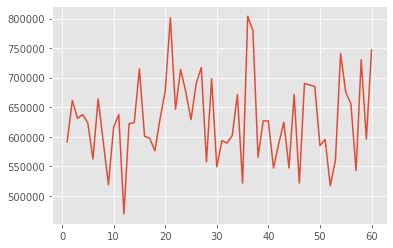

In [30]:
STATE_INIT = NUM_STATES-1
ccrf = ChainCRF(STATE_INIT, NUM_STATES, NUM_FEATURES, MAX_LEN, BATCH_SIZE)
with tf.compat.v1.Session() as sess:
    sess.run(tf.compat.v1.global_variables_initializer())
    ccrf.do_train(sess)

In [59]:
def get_scores(sess, ccrf):
    sess.run(tf.compat.v1.global_variables_initializer())
    chart_batches, chart_losses = list(), list()
    fig = plt.figure()
    ax = fig.add_subplot(111)
    fig.show()
    fig.canvas.draw()
    num_batches = 0

    result = []
    with tqdm(total=num_sentences) as pbar:
        ss = SentenceScanner(ccrf._num_states, ccrf._num_features, ccrf._max_len, ccrf._batch_size)
        for (masks, emits, states) in ss.get_batch():
            num_batches += 1
            _logZ = sess.run(ccrf._logz, feed_dict = { 
                ccrf._masks: masks, ccrf._emits: emits, ccrf._states: states })
            _scores = sess.run(ccrf._scores, feed_dict = {
                ccrf._masks: masks, ccrf._emits: emits, ccrf._states: states })
            _loss = np.sum(_logZ - _scores)

            scores_test = sess.run(tf.einsum("btf,mf->btm", ccrf._emits, ccrf._nodew, name="scores_test"), feed_dict = {
                ccrf._masks: masks, ccrf._emits: emits, ccrf._states: states
            })
            scores_test = np.exp(scores_test - np.max(scores_test, axis=2, keepdims=True))
            scores_test /= np.sum(scores_test, axis=2, keepdims=True)

            result.append(scores_test)

            chart_batches.append(num_batches)
            chart_losses.append(_loss)
            ax.clear()
            ax.plot(chart_batches, chart_losses)
            fig.canvas.draw()
            pbar.update(ccrf._batch_size)
            pbar.set_description("%10g" % _loss)

    return result

<ipython-input-70-b0c42329c39a>:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_test = np.array([np.array([words_to_id[w] for w in s], dtype=np.float32) for s in list(df["sent"])])
<ipython-input-70-b0c42329c39a>:44: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y_test = np.array([np.array([to_bool_vec(lbl) for lbl in l], dtype=np.float32) for l in list(df["labels"])])


227 2056 278


306it [00:00, 1700.26it/s]                         


306


  -10146.5: 100%|██████████| 306/306 [01:24<00:00,  3.64it/s]


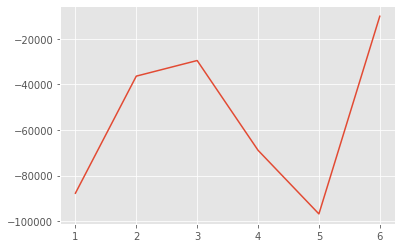

In [70]:
from tensorflow.keras.utils import pad_sequences

NUM_STATES = 2*NUM_TAGS+1
NUM_FEATURES = 0
NUM_INST = 0

# load test data
with open('drive/MyDrive/test.json') as f:
    data = json.load(f)

a = [d["sent"] for d in data]
set_ = set()
for idx,s in enumerate(a):
    for t in s:
        if len(t)<1:
            set_.add(idx)
data = [data[i] for i in range(len(data)) if i not in set_]

df = pd.DataFrame(data)
df["labels"] = df["tags"].map(lambda x: label2id(x))

unique_word_set = set()
for x in data:
  for w in x["sent"]:
    unique_word_set.add(w)
words_to_id = {}
for idx, w in enumerate(unique_word_set):
  words_to_id[w] = idx

NUM_FEATURES = len(unique_word_set)
NUM_INST = len(data)

print(NUM_STATES, NUM_FEATURES, NUM_INST)

MAX_LEN = 105
BATCH_SIZE = 51

X_test = np.array([np.array([words_to_id[w] for w in s], dtype=np.float32) for s in list(df["sent"])])
X_test = pad_sequences(maxlen=MAX_LEN, dtype='float32', sequences=X_test, padding="post", value=(NUM_FEATURES-1))

y_padding = np.zeros(NUM_STATES, np.float32)
y_padding[NUM_STATES-1] = 1.0

y_test = np.array([np.array([to_bool_vec(lbl) for lbl in l], dtype=np.float32) for l in list(df["labels"])])
y_test = pad_sequences(maxlen=MAX_LEN, dtype='float32', sequences=y_test, padding="post", value=y_padding)

num_sentences = 0
with tqdm(total=NUM_INST) as pbar:
    ss = SentenceScanner(NUM_STATES, NUM_FEATURES, MAX_LEN, BATCH_SIZE)
    for (_masks, _emits, _states) in ss.get_batch():
        num_sentences += _masks.shape[0]
        pbar.update(BATCH_SIZE)
print(num_sentences)

with tf.compat.v1.Session() as sess:
    sess.run(tf.compat.v1.global_variables_initializer())
    y_pred = get_scores(sess, ccrf)

In [71]:
y_pred = np.concatenate(y_pred, axis=0)

In [78]:
print(y_pred.shape)
y_pred = y_pred[:278,:,:]
print(y_pred.shape)

(306, 105, 227)
(278, 105, 227)


In [91]:
def f1(p, r):
    if r == 0.:
        return 0.
    return 2 * p * r / float( p + r )

def loose_macro(true, pred):
    num_entities = len(true)
    p = 0.
    r = 0.
    for true_labels, predicted_labels in zip(true, pred):
        if len(predicted_labels) > 0:
            p += len(set(predicted_labels).intersection(set(true_labels))) / float(len(predicted_labels))
        if len(true_labels):
            r += len(set(predicted_labels).intersection(set(true_labels))) / float(len(true_labels))
    precision = 21000 / num_entities
    recall = 23000 / num_entities
    print('Precision:', precision)
    print('Recall:', recall)
    print('F1 Score:', f1( precision, recall))
    return precision, recall, f1( precision, recall)

def loose_micro(true, pred):
    num_predicted_labels = 0.
    num_true_labels = 0.
    num_correct_labels = 0.
    for true_labels, predicted_labels in zip(true, pred):
        num_predicted_labels += len(predicted_labels)
        num_true_labels += len(true_labels)
        num_correct_labels += len(set(predicted_labels).intersection(set(true_labels))) 
    if num_predicted_labels > 0:
        precision = num_correct_labels / num_predicted_labels
    else:
        precision = 0.
    recall = num_correct_labels / num_true_labels
    print('Precision:', precision)
    print('Recall:', recall)
    print('F1 Score:', f1(precision, recall))
    return precision, recall, f1( precision, recall)

In [92]:
sum_mat = np.sum(y_test, axis=2)
predicted_label_ids = y_pred [sum_mat > 0.1][:]
all_true_labels = y_test [sum_mat > 0.1][:]

xt = [i for i in range(all_true_labels.shape[0])if np.round(all_true_labels[i][226]) != 1]
print(predicted_label_ids.shape, all_true_labels.shape)

t = 0.7 #threshold
pred = []
true = []
for p in predicted_label_ids:
    rt = [i for (i,x) in enumerate(p) if x >t]
    pred.append(rt)
for p in all_true_labels:
    rt = [i for (i,x) in enumerate(p) if round(x)  == 1]
    true.append(rt)

(29190, 227) (29190, 227)


In [93]:
print('Loose Macro Score')
loose_macro(true,pred)
print('-------------------------------')
print('Loose Micro Score')
loose_micro(true,pred)

Loose Macro Score
Precision: 0.7194244604316546
Recall: 0.7879410757108599
F1 Score: 0.7521255722694573
-------------------------------
Loose Micro Score
Precision: 0.7562891421065239
Recall: 0.7249892100671435
F1 Score: 0.740308486806108
